In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [42]:
Dataset_dir = ["./train.csv", "./store.csv","./test.csv"]
pd.options.display.max_columns = None

In [43]:
def load_data(dir):
    data = pd.read_csv(dir[0],parse_dates=[2])
    store = pd.read_csv(dir[1])
    test = pd.read_csv(dir[2],parse_dates=[3])
    return data,store,test

In [44]:
train,store,test = load_data(Dataset_dir)
train = train[train['Open'] != 0]
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
print(train.columns)
print(test.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [45]:
#对时间序列进行分析
#总的销售趋势2013-2015年
# train['date'] = pd.to_datetime(train.Date)
# data = train.loc[:,['Sales']]
# data = data.set_index(train.date)
# data.plot()

# weekly = data.resample('W').sum()
# weekly.plot()

# dayily = data.resample('D').sum()
# dayily.plot()

In [46]:
TESTID = test['Id']

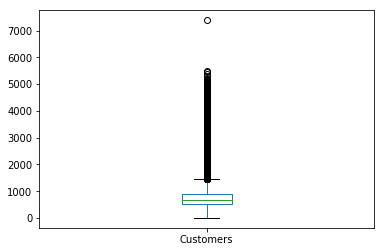

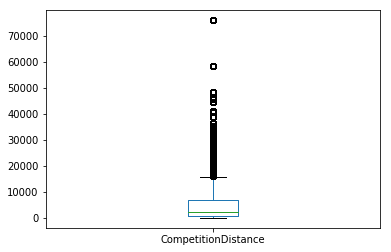

In [47]:
train.Customers.plot(kind='box')
plt.show()
train.CompetitionDistance.plot(kind='box')
plt.show()

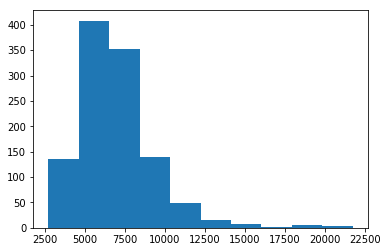

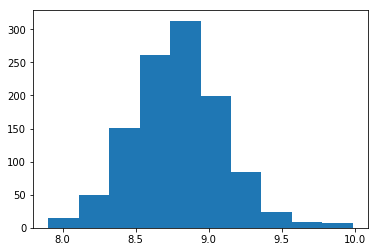

In [48]:
sales_mean = train.groupby('Store')['Sales'].mean()
plt.hist(sales_mean)
plt.show()
plt.hist(np.log1p(sales_mean))
plt.show()

In [49]:
Store_DaysWeek = train.groupby(['Store','DayOfWeek'])
sw_mean = Store_DaysWeek["Sales"].mean()

In [50]:
def build_feature(data,istrain):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #CART回归树不需要预处理数据和NAn值
#     distance_max = max(data.CompetitionDistance)
#     data.CompetitionDistance.mask(data.CompetitionDistance.isna(),other=distance_max,inplace=True)
#     print(data.CompetitionDistance.isnull().any())
#     min_max_scaler = MinMaxScaler()
#     scaledata = min_max_scaler.fit_transform(data[['CompetitionDistance']])
#     data.drop("CompetitionDistance",axis=1)
#     data['CompetitionDistance'] = scaledata
    #时间序列问题 需要考虑进时间的因素
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    
    if istrain:
        #data.drop(['Store','Open','Date','Customers','PromoInterval',],axis=1,inplace=True)
        data.drop(['Store','Open','Date','Customers','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    else:
        #data.drop(['Id','Store','Open','Date','PromoInterval',],axis=1,inplace=True)
        data.drop(['Id','Store','Open','Date','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    print(data.columns)

In [51]:
#build train data
build_feature(train,True)
#build test data
build_feature(test,False)

Index(['DayOfWeek', 'Sales', 'Promo', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')
Index(['DayOfWeek', 'Promo', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')


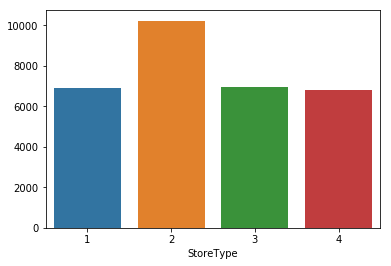

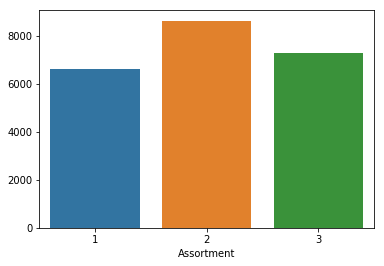

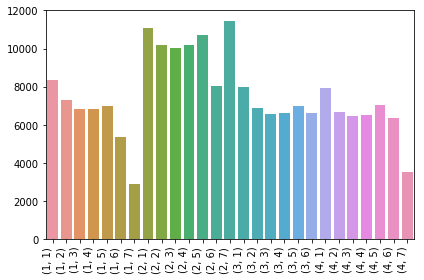

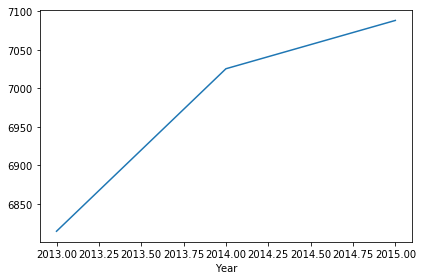

In [53]:
ST_gp = train.groupby('StoreType')['Sales'].agg('mean')
import seaborn as sns
sns.barplot(ST_gp.index,ST_gp.values)
plt.show()

As_gp = train.groupby('Assortment')['Sales'].agg('mean')
sns.barplot(As_gp.index,As_gp.values)
plt.show()
Dayweek_gp = train.groupby(['StoreType','DayOfWeek'])['Sales'].agg('mean')
ax = sns.barplot(Dayweek_gp.index,Dayweek_gp.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

#每年销售额的趋势
YearS_gp = train.groupby(['Year'])['Sales'].agg("mean")
ax2 = sns.lineplot(YearS_gp.index,YearS_gp.values)
plt.tight_layout()
plt.show()

In [54]:
#split train vaild data
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
Y_train = X_train["Sales"]
Y_valid = X_valid["Sales"]
X_train.drop("Sales",axis=1,inplace=True)
X_valid.drop("Sales",axis=1,inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


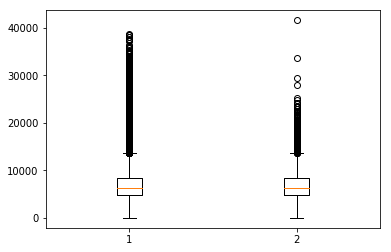

In [55]:
plt.boxplot([Y_train,Y_valid])
plt.show()

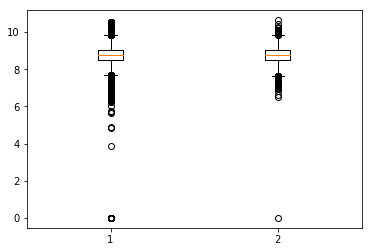

In [56]:
Y_train = np.log1p(Y_train)
Y_valid = np.log1p(Y_valid)
plt.boxplot([Y_train,Y_valid])
plt.show()

In [57]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [67]:
params = {"objective": "reg:linear",
          "eta": 0.15,
          "max_depth": 12,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300

dtrain = xgb.DMatrix(X_train, Y_train)
dvalid = xgb.DMatrix(X_valid, Y_valid)
dtest = xgb.DMatrix(test)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
ret = {}
import time
start = time.time()
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)
end = time.time()
print("Train use time:",end-start)

[0]	eval-rmse:7.02656	train-rmse:7.03075	eval-rmspe:0.999147	train-rmspe:0.999169
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:5.97529	train-rmse:5.97938	eval-rmspe:0.99734	train-rmspe:0.997369
[2]	eval-rmse:5.08264	train-rmse:5.08601	eval-rmspe:0.993353	train-rmspe:0.993392
[3]	eval-rmse:4.32384	train-rmse:4.32666	eval-rmspe:0.985764	train-rmspe:0.985817
[4]	eval-rmse:3.67916	train-rmse:3.68131	eval-rmspe:0.972951	train-rmspe:0.97302
[5]	eval-rmse:3.13142	train-rmse:3.13319	eval-rmspe:0.953387	train-rmspe:0.953477
[6]	eval-rmse:2.66675	train-rmse:2.66818	eval-rmspe:0.925903	train-rmspe:0.92603
[7]	eval-rmse:2.27197	train-rmse:2.27291	eval-rmspe:0.890479	train-rmspe:0.890667
[8]	eval-rmse:1.93752	train-rmse:1.93814	eval-rmspe:0.847198	train-rmspe:0.847513
[9]	eval-rmse:1.6528	train-rmse:1.65308	eval-rmspe:0.797841	train-rmspe:0.798327
[10]	eval-rmse:1.41224	train-rmse:1.4

[96]	eval-rmse:0.14717	train-rmse:0.126625	eval-rmspe:0.129727	train-rmspe:0.167664
[97]	eval-rmse:0.146943	train-rmse:0.126095	eval-rmspe:0.129434	train-rmspe:0.167273
[98]	eval-rmse:0.146803	train-rmse:0.125853	eval-rmspe:0.129289	train-rmspe:0.166863
[99]	eval-rmse:0.146625	train-rmse:0.125607	eval-rmspe:0.12901	train-rmspe:0.166396
[100]	eval-rmse:0.14627	train-rmse:0.12519	eval-rmspe:0.128556	train-rmspe:0.165849
[101]	eval-rmse:0.145962	train-rmse:0.124732	eval-rmspe:0.128181	train-rmspe:0.16545
[102]	eval-rmse:0.145792	train-rmse:0.124487	eval-rmspe:0.127998	train-rmspe:0.165152
[103]	eval-rmse:0.1456	train-rmse:0.123879	eval-rmspe:0.127713	train-rmspe:0.164715
[104]	eval-rmse:0.145141	train-rmse:0.123349	eval-rmspe:0.127127	train-rmspe:0.164284
[105]	eval-rmse:0.145234	train-rmse:0.123076	eval-rmspe:0.127045	train-rmspe:0.164134
[106]	eval-rmse:0.14497	train-rmse:0.122752	eval-rmspe:0.126716	train-rmspe:0.163819
[107]	eval-rmse:0.144775	train-rmse:0.122311	eval-rmspe:0.126535	t

[192]	eval-rmse:0.138043	train-rmse:0.10332	eval-rmspe:0.116151	train-rmspe:0.126621
[193]	eval-rmse:0.137992	train-rmse:0.103142	eval-rmspe:0.116003	train-rmspe:0.126491
[194]	eval-rmse:0.138039	train-rmse:0.103099	eval-rmspe:0.116041	train-rmspe:0.126412
[195]	eval-rmse:0.138023	train-rmse:0.10307	eval-rmspe:0.116016	train-rmspe:0.126449
[196]	eval-rmse:0.137988	train-rmse:0.102945	eval-rmspe:0.116071	train-rmspe:0.126354
[197]	eval-rmse:0.137907	train-rmse:0.102841	eval-rmspe:0.116034	train-rmspe:0.126327
[198]	eval-rmse:0.137769	train-rmse:0.102705	eval-rmspe:0.115922	train-rmspe:0.126306
[199]	eval-rmse:0.1377	train-rmse:0.102561	eval-rmspe:0.115841	train-rmspe:0.126123
[200]	eval-rmse:0.137612	train-rmse:0.102454	eval-rmspe:0.115731	train-rmspe:0.125858
[201]	eval-rmse:0.137606	train-rmse:0.102304	eval-rmspe:0.115673	train-rmspe:0.125474
[202]	eval-rmse:0.137506	train-rmse:0.10215	eval-rmspe:0.115575	train-rmspe:0.125348
[203]	eval-rmse:0.137512	train-rmse:0.101966	eval-rmspe:0.1

[288]	eval-rmse:0.136605	train-rmse:0.092144	eval-rmspe:0.113354	train-rmspe:0.10035
[289]	eval-rmse:0.136632	train-rmse:0.092127	eval-rmspe:0.113356	train-rmspe:0.100325
[290]	eval-rmse:0.136641	train-rmse:0.092029	eval-rmspe:0.113392	train-rmspe:0.100255
[291]	eval-rmse:0.136517	train-rmse:0.091945	eval-rmspe:0.113343	train-rmspe:0.099851
[292]	eval-rmse:0.136541	train-rmse:0.091886	eval-rmspe:0.113254	train-rmspe:0.099787
[293]	eval-rmse:0.136503	train-rmse:0.091797	eval-rmspe:0.113199	train-rmspe:0.099611
[294]	eval-rmse:0.136476	train-rmse:0.091621	eval-rmspe:0.113121	train-rmspe:0.099573
[295]	eval-rmse:0.136511	train-rmse:0.09156	eval-rmspe:0.11314	train-rmspe:0.099499
[296]	eval-rmse:0.136467	train-rmse:0.091518	eval-rmspe:0.113088	train-rmspe:0.09948
[297]	eval-rmse:0.136474	train-rmse:0.091463	eval-rmspe:0.113105	train-rmspe:0.099424
[298]	eval-rmse:0.136467	train-rmse:0.091384	eval-rmspe:0.11311	train-rmspe:0.099346
[299]	eval-rmse:0.136444	train-rmse:0.09131	eval-rmspe:0.11

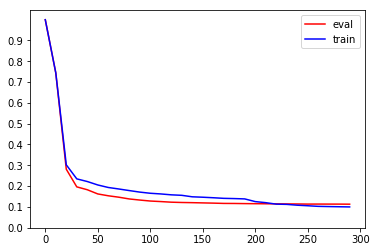

In [68]:
evaldata = ret['eval']['rmspe'][0:300:10]
traindata = ret['train']['rmspe'][0:300:10]
plt.plot(range(0,300,10),evaldata,color='red',label="eval")
plt.plot(range(0,300,10),traindata,color='blue',label="train")
plt.legend(loc='best')
y_tick = np.arange(0,1,0.1)
plt.yticks(y_tick)
plt.show()

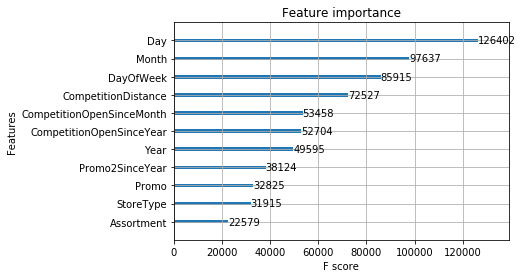

In [69]:
#从最终的训练importnace中看果然是时间序列影响比较大
xgb.plot_importance(gbm)

In [70]:
#预测测试数据
regetTest = pd.read_csv("./test.csv")
replaceID = regetTest[regetTest.Open == 0.0]['Id']
print(replaceID.values)
test_probs = gbm.predict(dtest)
result = pd.DataFrame({"Id": TESTID , 'Sales': np.exp(test_probs)})
result.loc[result['Id'].isin(replaceID.values),'Sales'] = 0

[  544   677   841 ... 40230 40231 40232]


In [71]:
#预测测试数据输出
result.to_csv("xgboost_submission.csv", index=False)